In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import numpy as np
from tqdm import tqdm
import torch

from bokeh.plotting import figure, show, output_file, save
from bokeh.layouts import gridplot
from bokeh.io import output_notebook
from bokeh.palettes import Viridis, Category10, Category20
from bokeh.io import export_svg
output_notebook()

Loading BokehJS ...

In [2]:
from metamod.control import LinearNetEq, LinearNetControl, LinearNetConstrainedG
from metamod.tasks import AffineCorrelatedGaussian, MNIST, SemanticTask
from metamod.trainers import two_layer_training
from metamod.networks import LinearNet
from metamod.utils import plot_lines, plot_weight_ev, check_dir, save_var, get_date_time

Loading BokehJS ...

In [3]:
run_name = "constrained_g"
results_path = "../results"

In [4]:
results_dict = {}

In [5]:
dataset_params = {"batch_size": 32,
                  "h_levels": 4}

dataset = SemanticTask(**dataset_params)

In [6]:
model_params = {"learning_rate": 5e-3,
                "hidden_dim": 20,
                "intrinsic_noise": 0.0,
                "reg_coef": 0.0,
                "input_dim": dataset.input_dim,
                "output_dim": dataset.output_dim,
                "W1_0": None,
                "W2_0": None}

model = LinearNet(**model_params)

In [7]:
n_steps = 8000
save_weights_every = 20

iters, loss, weights_iter, weights = two_layer_training(model=model, dataset=dataset, n_steps=n_steps, save_weights_every=save_weights_every)

results_dict["iters"] = iters
results_dict["Loss_t_sim"] = loss
results_dict["weights_sim"] = weights
results_dict["weights_iters_sim"] = weights_iter

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8000/8000 [00:06<00:00, 1202.62it/s]


In [8]:
weights[0].shape

(400, 20, 8)

In [9]:
init_W1 = weights[0][0, ...]
init_W2 = weights[1][0, ...]

init_weights = [init_W1, init_W2]
input_corr, output_corr, input_output_corr, expected_y, expected_x = dataset.get_correlation_matrix()

time_span = np.arange(0, len(iters))*model_params["learning_rate"]
results_dict["time_span"] = time_span

In [10]:
init_W2.shape

(15, 20)

In [11]:
equation_params = {"in_cov": input_corr,
                   "out_cov": output_corr,
                   "in_out_cov": input_output_corr,
                   # "expected_y": expected_y,
                   # "expected_x": expected_x,
                   "init_weights": init_weights,
                   "n_steps": n_steps,
                   "reg_coef": model_params["reg_coef"],
                   "intrinsic_noise": model_params["intrinsic_noise"],
                   "learning_rate": model_params["learning_rate"],
                   "time_constant": 1.0}

In [12]:
solver = LinearNetEq(**equation_params)

In [13]:
control_params = {**equation_params,
                  "control_lower_bound": -0.5,
                  "control_upper_bound": 0.5,
                  "gamma": 0.99,
                  "cost_coef": 0.1,
                  "reward_convertion": 1.0,
                  "init_g": None,
                  "control_lr": 1.0,
                  "degree_of_control": init_W2.shape[0],
                  "control_base": "neural_base",
                  "update_first_layer": False,
                  "update_second_layer": True}

In [14]:
control = LinearNetConstrainedG(**control_params)

In [15]:
sim_weights1 = weights[0]
sim_weights2 = weights[1]
print(sim_weights1.shape, sim_weights2.shape)

(400, 20, 8) (400, 15, 20)


In [16]:
W1_t, W2_t = solver.get_weights(time_span, get_numpy=True)
Loss_t = solver.get_loss_function(W1_t, W2_t, get_numpy=True)

results_dict["W1_t_eq"] = W1_t
results_dict["W2_t_eq"] = W2_t
results_dict["Loss_t_eq"] = Loss_t

In [17]:
W1_t_control, W2_t_control = control.get_weights(time_span, get_numpy=True)
Loss_t_control = control.get_loss_function(W1_t_control, W2_t_control, get_numpy=True)

results_dict["W1_t_control_init"] = W1_t_control
results_dict["W2_t_control_init"] = W2_t_control
results_dict["Loss_t_control_init"] = Loss_t_control
results_dict["control_signal_init"] = (control.g1_tilda, control.g2_tilda)

In [18]:
losses = (loss, Loss_t, Loss_t_control)
colors = (Category10[10][0], Category10[10][0], Category10[10][1])
legends = ("Simulation", "Equation", "Init Control")
alphas = (0.3, 1, 1)

s = plot_lines(iters, losses, legends, alphas, colors)
show(s)

In [19]:
flat_W1_t = np.reshape(weights[0], (weights[0].shape[0], -1))
flat_eq_W1_t = np.reshape(W1_t, (W1_t.shape[0], -1))

flat_W2_t = np.reshape(weights[1], (weights[1].shape[0], -1))
flat_eq_W2_t = np.reshape(W2_t, (W2_t.shape[0], -1))

In [20]:
weight_plot1 = plot_weight_ev(flat_W1_t, flat_eq_W1_t, iters=weights_iter, iters_set2=iters, title="W1")
weight_plot2 = plot_weight_ev(flat_W2_t, flat_eq_W2_t, iters=weights_iter, iters_set2=iters, title="W2")
grid = gridplot([weight_plot1, weight_plot2], ncols=2, width=600, height=500)
show(grid)

## Optimizing control signal

In [21]:
iter_control = 100
control_params["iters_control"] = iter_control
cumulated_reward = []

In [22]:
for i in tqdm(range(iter_control)):
    R = control.train_step(get_numpy=True)
    # print("cumulated reward:", R)
    cumulated_reward.append(R)
cumulated_reward = np.array(cumulated_reward).astype(float)
results_dict["cumulated_reward_opt"] = cumulated_reward

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [10:20<00:00,  6.20s/it]


In [23]:
opt = plot_lines(np.arange(iter_control), (cumulated_reward,), x_axis_label="gradient steps on control", y_axis_label="Cumulated reward")
show(opt)

In [24]:
W1_t_opt, W2_t_opt = control.get_weights(time_span, get_numpy=True)
Loss_t_opt = control.get_loss_function(W1_t_opt, W2_t_opt, get_numpy=True)

results_dict["W1_t_control_opt"] = W1_t_opt
results_dict["W2_t_control_opt"] = W2_t_opt
results_dict["Loss_t_control_opt"] = Loss_t_opt

In [25]:
losses = (loss, Loss_t, Loss_t_opt)
colors = (Category10[10][0], Category10[10][0], Category10[10][1])
legends = ("Real Non-linear", "Approximation", "Approximated Optimized Control")
alphas = (0.3, 1, 1)

s = plot_lines(iters, losses, legends, alphas, colors)
show(s)

In [26]:
g1_tilda = torch.clone(control.g1_tilda).detach()
g2_tilda = torch.clone(control.g2_tilda).detach()
control_signal = (g1_tilda, g2_tilda)
W1_0, W2_0 = control_params["init_weights"]
results_dict["control_signal"] = control_signal

In [27]:
g1_tilda.shape, g2_tilda.shape, W1_0.shape

(torch.Size([8000, 20, 8]), torch.Size([8000, 15, 20]), (20, 8))

In [28]:
reset_model_params = model_params.copy()
reset_model_params["W1_0"] = W1_0
reset_model_params["W2_0"] = W2_0

reset_model = LinearNet(**reset_model_params)

In [29]:
iters, loss_OPT, weights_iter_OPT, weights_OPT = two_layer_training(model=reset_model,
                                                                    dataset=dataset,
                                                                    n_steps=n_steps,
                                                                    save_weights_every=save_weights_every,
                                                                    control_signal=control_signal)
results_dict["Loss_t_sim_OPT"] = loss_OPT
results_dict["weights_sim_OPT"] = weights_OPT
results_dict["weights_iters_sim_OPT"] = weights_iter_OPT
results_dict["iters_OPT"] = iters

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8000/8000 [00:06<00:00, 1209.87it/s]


In [30]:
losses = (loss, Loss_t, Loss_t_opt, loss_OPT)
colors = (Category10[10][0], Category10[10][0], Category10[10][1], Category10[10][1])
legends = ("Real Non-linear", "Approximation", "Approximated Optimized Control", "Optimized Non-linear")
alphas = (0.3, 1, 1, 0.3)

s = plot_lines(iters, losses, legends, alphas, colors)
show(s)

In [31]:
results_dict.keys()

dict_keys(['iters', 'Loss_t_sim', 'weights_sim', 'weights_iters_sim', 'time_span', 'W1_t_eq', 'W2_t_eq', 'Loss_t_eq', 'W1_t_control_init', 'W2_t_control_init', 'Loss_t_control_init', 'control_signal_init', 'cumulated_reward_opt', 'W1_t_control_opt', 'W2_t_control_opt', 'Loss_t_control_opt', 'control_signal', 'Loss_t_sim_OPT', 'weights_sim_OPT', 'weights_iters_sim_OPT', 'iters_OPT'])

In [32]:
params_dict = {"dataset_params": dataset_params,
               "model_params": model_params,
               "equation_params": equation_params,
               "control_params": control_params,
               "reset_model_params": reset_model_params}

In [33]:
import os
time_str = get_date_time()
saving_path = os.path.join(results_path, run_name+"_"+time_str)

In [34]:
save_var(results_dict, "results.pkl", results_path=saving_path)

In [35]:
save_var(params_dict, "params.pkl", results_path=saving_path)

In [36]:
nus = control.nus_2.detach().cpu().numpy()

In [37]:
nus.shape

(8000, 1, 1, 15)

In [38]:
import matplotlib.pyplot as plt

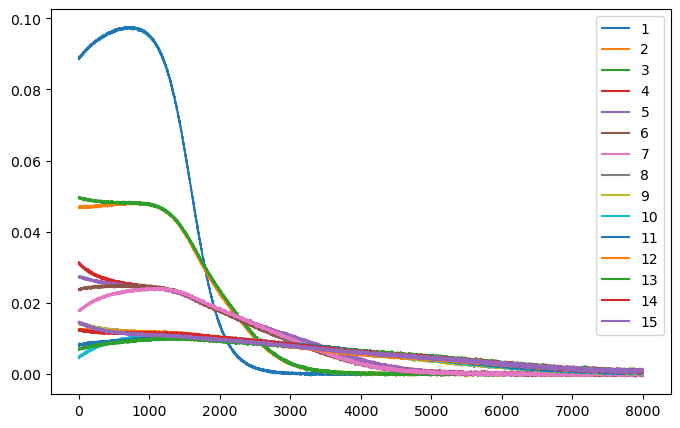

In [39]:
f, ax = plt.subplots(1, 1, figsize=(8, 5))
for i in range(nus.shape[-1]):
    ax.plot(iters, nus[:, 0, 0, i], label=str(i+1))
plt.legend()
plt.show()